In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [2]:
# We also set some seeds to make this reproducable.
np.random.seed(42)
_ = torch.manual_seed(42)

## Dataset

In [3]:
path_to_file = './../dataset_and_other_models/dataset/'
df_train_x = pd.read_csv(path_to_file + 'train_x.csv')
df_train_y = pd.read_csv(path_to_file + 'train_y.csv')
df_train_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [4]:
df_test_x = pd.read_csv(path_to_file + 'test_x.csv')
df_test_y = pd.read_csv(path_to_file + 'test_y.csv')
df_test_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [5]:
df_test = pd.concat([df_test_x, df_test_y], axis=1)
df_test = df_test.astype('float32')

In [6]:
df_train = pd.concat([df_train_x, df_train_y], axis=1)
df_train = df_train.astype('float32')

In [7]:
df_val = df_train.sample(frac=0.25)
df_train = df_train.drop(df_val.index)

In [8]:
df_train['Status'].describe()

count    315.000000
mean       0.384127
std        0.487162
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Status, dtype: float64

In [9]:
df_train.columns

Index(['Y', 'AF', 'AQ', 'AY', 'BC', 'BE', 'BG', 'BH', 'BI', 'BL', 'BM', 'BP',
       'CY', 'DC', 'DE', 'DW', 'DX', 'DY', 'Age', 'metastasis', 'secondprim',
       'Status', 'Survival'],
      dtype='object')

In [10]:
cols_standardize =  ['BE', 'BC', 'AY', 'Age'] # Numerical columns
cols_leave = ['Y', 'AF', 'BG', 'BH', 'BI', 'BL',
              'BM', 'BP', 'CY', 'DC',
              'DW', 'DX', 'DY', 'metastasis', 'secondprim'] # Binary columns
cols_categorical =  ['AQ', 'DE'] # Categorical Columns

print(len(cols_standardize) + len(cols_leave) + len(cols_categorical))

21


In [11]:
# Turn them to binary features (0, 1)
df_train[cols_leave] -= 1
df_val[cols_leave] -= 1
df_test[cols_leave] -= 1

In [12]:
df_train['AY'].describe()
df_train['AQ'].describe()

count    315.000000
mean       2.542857
std        1.802485
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max       11.000000
Name: AQ, dtype: float64

In [13]:
# Preprocess different types of features.
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong(min_per_category=5)) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [14]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [15]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

## Discretization

In [16]:
# Discretization
num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['Survival'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

In [17]:
labtrans.cuts

array([    0.,    55.,    90.,   110.,   153.,   201.,   225.,   253.,
         293.,   364.,   425.,   462.,   608.,   718.,   880.,   982.,
        1321.,  1579.,  2048., 10000.], dtype=float32)

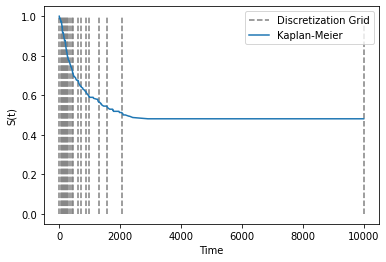

In [18]:
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [19]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

In [20]:
x_train.shapes()

((315, 19), (315, 2))

## Neural Network

In [21]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [22]:
x_train[1]

array([[1, 1],
       [2, 1],
       [2, 9],
       [2, 9],
       [2, 1],
       [5, 7],
       [2, 2],
       [1, 3],
       [2, 1],
       [0, 8],
       [2, 1],
       [2, 9],
       [2, 1],
       [2, 1],
       [2, 9],
       [5, 1],
       [2, 9],
       [2, 9],
       [3, 9],
       [4, 9],
       [2, 2],
       [2, 2],
       [2, 1],
       [5, 9],
       [4, 9],
       [1, 1],
       [1, 1],
       [2, 9],
       [2, 9],
       [2, 9],
       [0, 1],
       [1, 9],
       [2, 5],
       [2, 2],
       [2, 1],
       [2, 1],
       [2, 8],
       [2, 9],
       [2, 8],
       [1, 8],
       [4, 1],
       [2, 9],
       [5, 9],
       [5, 2],
       [4, 9],
       [2, 2],
       [2, 9],
       [1, 9],
       [4, 1],
       [1, 9],
       [0, 9],
       [2, 9],
       [5, 2],
       [4, 9],
       [2, 9],
       [1, 1],
       [2, 3],
       [0, 1],
       [1, 9],
       [2, 6],
       [5, 8],
       [4, 1],
       [1, 9],
       [1, 3],
       [2, 9],
       [2, 7],
       [5,

In [23]:
num_embeddings, embedding_dims

(array([ 6, 10], dtype=int64), array([3, 5], dtype=int64))

In [24]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 128, 128, 64]
batch_norm = True
dropout = 0.65

# Opt1: {'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.8, 'lr': 0.05}
# Opt2: {'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.65, 'lr': 0.05}
# Opt3: {'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.65, 'lr': 0.05}
# Opt4: {'num_nodes': [64, 64, 64, 64], 'dropout': 0.7, 'lr': 0.05}
# Opt5: {'num_nodes': [64, 64, 128, 64, 64], 'dropout': 0.75, 'lr': 0.05}
# Opt6: {'num_nodes': [64, 128, 128, 64], 'dropout': 0.75, 'lr': 0.05}
# Opt7: {'num_nodes': [64, 128, 128, 64], 'dropout': 0.7, 'lr': 0.05}
# Opt7: {'num_nodes': [64, 128, 128, 64], 'dropout': 0.65, 'lr': 0.05} BEST
# Opt7: {'num_nodes': [64, 128, 128, 128, 64], 'dropout': 0.65, 'lr': 0.05}

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [25]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(6, 3)
      (1): Embedding(10, 5)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=27, out_features=64, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.65, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=64, out_features=128, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.65, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## Training the model

In [26]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)

c:\users\keivan\appdata\local\programs\python\python37\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  p.data = p.data.add(-weight_decay * eta, p.data)


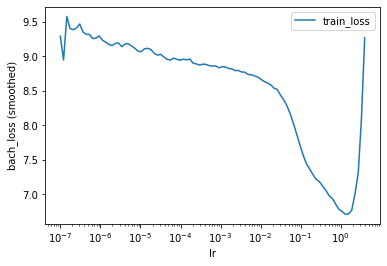

In [27]:
batch_size = 128
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [28]:
model.optimizer.param_groups[0]['lr']

0.12915496650148922

In [29]:
lrfind.get_best_lr()

0.12915496650148922

In [30]:
model.optimizer.set_lr(0.05)

In [31]:
epochs = 200
callbacks = [tt.cb.EarlyStoppingCycle(min_delta=0, patience=10,)]

In [32]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose=0,
                val_data=val)

Wall time: 12 s


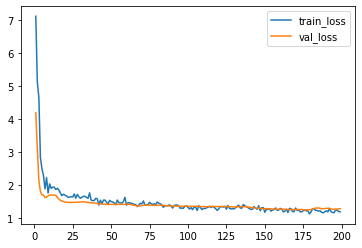

In [33]:
_ = log.to_pandas().iloc[1:].plot()

In [34]:
log.to_pandas().val_loss.min()

1.2523897886276245

In [35]:
log.to_pandas().train_loss.min()

1.1326252619425456

## Prediction

In [36]:
surv_cdi = model.interpolate(100).predict_surv_df(x_test)
surv_cdi_train = model.interpolate(100).predict_surv_df(x_train)
surv_cdi_val = model.interpolate(100).predict_surv_df(x_val)

<Figure size 720x288 with 0 Axes>

<Figure size 432x720 with 0 Axes>

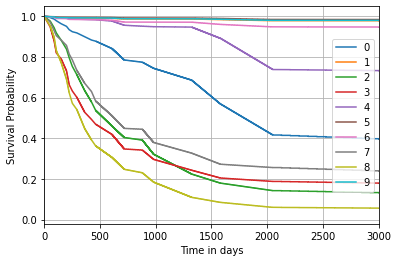

In [46]:
plt.figure().set_figwidth(10)
plt.figure().set_figheight(10)
surv_cdi.iloc[:, 0:10].plot(drawstyle='steps-post')
plt.ylabel('Survival Probability')
_ = plt.xlabel('Time in days')
plt.xlim(0, 3000)
plt.grid(True)
# f = plt.figure()
plt.savefig('myplot-LH.jpg', dpi=400)

In [38]:
p_df = surv_cdi.iloc[:, 0:10]

In [39]:
p_df.head()

,0,1,2,3,4,5,6,7,8,9
0.00,0.999985,1.000000,0.999794,0.999528,1.000000,1.000000,1.000000,0.999898,0.998743,1.000000
0.55,0.999918,0.999967,0.999555,0.999005,0.999977,0.999980,0.999949,0.999605,0.998276,0.999970
1.10,0.999851,0.999934,0.999316,0.998481,0.999955,0.999960,0.999899,0.999312,0.997810,0.999941
1.65,0.999784,0.999901,0.999078,0.997958,0.999932,0.999941,0.999849,0.999019,0.997344,0.999911
2.20,0.999717,0.999869,0.998839,0.997434,0.999910,0.999921,0.999798,0.998726,0.996878,0.999881


In [40]:
list(p_df[0])

[0.9999852180480957,
 0.9999180436134338,
 0.9998509287834167,
 0.9997837543487549,
 0.999716579914093,
 0.9996494054794312,
 0.9995822906494141,
 0.9995151162147522,
 0.9994479417800903,
 0.9993808269500732,
 0.9993136525154114,
 0.9992464780807495,
 0.9991793036460876,
 0.9991121888160706,
 0.9990450143814087,
 0.9989778399467468,
 0.998910665512085,
 0.9988435506820679,
 0.998776376247406,
 0.9987092018127441,
 0.998642086982727,
 0.9985749125480652,
 0.9985077381134033,
 0.9984405636787415,
 0.9983734488487244,
 0.9983062744140625,
 0.9982390999794006,
 0.9981719851493835,
 0.9981048107147217,
 0.9980376362800598,
 0.997970461845398,
 0.9979033470153809,
 0.997836172580719,
 0.9977689981460571,
 0.99770188331604,
 0.9976347088813782,
 0.9975675344467163,
 0.9975003600120544,
 0.9974332451820374,
 0.9973660707473755,
 0.9972988963127136,
 0.9972317218780518,
 0.9971646070480347,
 0.9970974326133728,
 0.9970302581787109,
 0.9969631433486938,
 0.996895968914032,
 0.9968287944793701,
 

In [41]:
import json
with open('diagram/x.json', 'w') as f:
    f.write(json.dumps(list(p_df.index), indent=4))

In [42]:
for i in range(10):
    with open(f'diagram/y_{i}.json', 'w') as f:
        f.write(json.dumps(list(p_df[i]), indent=4))

## Evaluation

### Test

In [43]:
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
ev_cdi.concordance_td()#, ev_chi.concordance_td()

0.8754301445285616

### Train

In [44]:
durations_train, events_train = get_target(df_train)
ev_cdi_train = EvalSurv(surv_cdi_train, durations_train, events_train, censor_surv='km')
ev_cdi_train.concordance_td()

0.8928793670548493

### Validation

In [45]:
durations_val, events_val = get_target(df_val)
ev_cdi_val = EvalSurv(surv_cdi_val, durations_val, events_val, censor_surv='km')
ev_cdi_val.concordance_td()

0.8522050059594756

In [300]:
# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid = np.arange(365, 1826, 30)#np.arange(365, 2400, 30)
ev_cdi.integrated_brier_score(time_grid)#, ev_chi.integrated_brier_score(time_grid)

0.10507537473863475

In [301]:
# time_grid = np.linspace(durations_train.min(), durations_train.max(), 100)
time_grid = np.arange(365, 1826, 30)#np.arange(365, 2400, 30)
ev_cdi_train.integrated_brier_score(time_grid)#, ev_chi.integrated_brier_score(time_grid)

0.07669664350258845

In [302]:
# time_grid = np.linspace(durations_train.min(), durations_train.max(), 100)
time_grid = np.arange(365, 1826, 30)#np.arange(365, 2400, 30)
ev_cdi_val.integrated_brier_score(time_grid)#, ev_chi.integrated_brier_score(time_grid)

0.10628416537878045

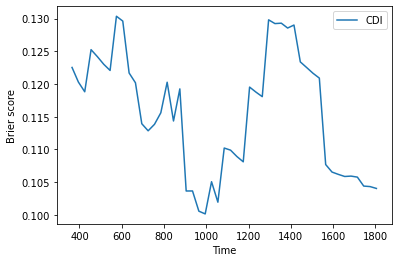

In [254]:
ev_cdi.brier_score(time_grid).rename('CDI').plot()
# ev_chi.brier_score(time_grid).rename('CHI').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [42]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features

nets = [[32, 32, 32, 32, 32, 32], [16, 16, 16, 16, 16, 16], [32, 16, 16, 16, 32]]
droputs = [0.65, 0.8]
lrs = [0.02, 0.05]


epochs = 2048
callbacks = [] #[tt.cb.EarlyStoppingCycle()]
verbose = False

cv = []

for num_nodes in nets:
    for dropout in droputs:
        for lr in lrs:       
            params = {'num_nodes': num_nodes, 'dropout': dropout, 'lr': lr}
            print(params)
            batch_norm = True
            net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)
            
            optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
            
            model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)
            model.optimizer.set_lr(lr)

            log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)
            
            score = {'Validation Error': log.to_pandas().val_loss.min(), 'Train Error': log.to_pandas().train_loss.min()}
            print(score)
            
            cv.append([params, score['Validation Error']])
            
            print('---------------')


{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.65, 'lr': 0.02}
{'Validation Error': 1.4433788061141968, 'Train Error': 1.2472617228825886}
---------------
{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.65, 'lr': 0.05}
{'Validation Error': 1.3813368082046509, 'Train Error': 1.1609439651171367}
---------------
{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.8, 'lr': 0.02}
{'Validation Error': 1.6199661493301392, 'Train Error': 1.5316903591156006}
---------------
{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.8, 'lr': 0.05}
{'Validation Error': 1.5243312120437622, 'Train Error': 1.391720751921336}
---------------
{'num_nodes': [16, 16, 16, 16, 16, 16], 'dropout': 0.65, 'lr': 0.02}
{'Validation Error': 1.55294930934906, 'Train Error': 1.4435030221939087}
---------------
{'num_nodes': [16, 16, 16, 16, 16, 16], 'dropout': 0.65, 'lr': 0.05}
{'Validation Error': 1.3955285549163818, 'Train Error': 1.2173844973246257}
---------------
{'num_nodes': [16, 16, 16, 16, 16, 16],

In [43]:
with open('hyperparameters_LH2.npy', 'wb') as f:
    np.save(f, np.array(cv))

In [111]:
best_params = [{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.8, 'lr': 0.05},
               {'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.65, 'lr': 0.05},
               {'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.65, 'lr': 0.05}]

In [59]:
cv

[[{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.65, 'lr': 0.02},
  1.4433788061141968],
 [{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.65, 'lr': 0.05},
  1.3813368082046509],
 [{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.8, 'lr': 0.02},
  1.6199661493301392],
 [{'num_nodes': [32, 32, 32, 32, 32, 32], 'dropout': 0.8, 'lr': 0.05},
  1.5243312120437622],
 [{'num_nodes': [16, 16, 16, 16, 16, 16], 'dropout': 0.65, 'lr': 0.02},
  1.55294930934906],
 [{'num_nodes': [16, 16, 16, 16, 16, 16], 'dropout': 0.65, 'lr': 0.05},
  1.3955285549163818],
 [{'num_nodes': [16, 16, 16, 16, 16, 16], 'dropout': 0.8, 'lr': 0.02},
  1.638424277305603],
 [{'num_nodes': [16, 16, 16, 16, 16, 16], 'dropout': 0.8, 'lr': 0.05},
  1.637363076210022],
 [{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.65, 'lr': 0.02},
  1.4155563116073608],
 [{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.65, 'lr': 0.05},
  1.359791874885559],
 [{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.8, 'lr': 0.02},
